### Implementation of a handwriting recognition AI algorithm using Hidden Markov Models (HMM), using Python in jupyter notebook.
### Student Name: Gargi Darade.
### Subject/Class: CMPS 451 Artificial Intelligence.

In [2]:
#Import the required libraries
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from collections import Counter
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from colorama import init, Style


In [56]:
#define helper functions

#To use image sequences as input for a Hidden Markov Model (HMM), 
#you need to transform the multi-dimensional 
#image data into a 1D array or a sequence of vectors, 
#which can be understood as a time series by the HMM. 
#Convert the multi-dimensional data into a 1D array, 
#where each element represents a pixel or feature vector. 
#Python NumPy: Use the .flatten() or .reshape() methods. 
#Keras/TensorFlow: Employ the Flatten() layer in your neural network architecture.     

# Flatten image sequences for HMM input
def flatten_image_sequence(image_sequence):
    n_samples, seq_length, n_features = image_sequence.shape
    return image_sequence.reshape(n_samples * seq_length, n_features)


def resize_image(image, new_width, new_height):
    """resize an image by keeping aspect ratio and atlest keep new width or height."""
    
    #if not isinstance(image, np.ndarray):
    #    image = np.array(image)
    #if image.dtype != np.uint8:
    #    image = image.astype(np.uint8)   
    
    width, height = image.size
    #print("Original Image shape: W:"+str(width)+" H:"+str(height))
    
    aspect_ratio = width / height
    if width > new_width or height > new_height:
        if width / new_width >= height / new_height:
            final_width = new_width
            final_height = int(new_width / aspect_ratio)
        else:
            final_height = new_height
            final_width = int(new_height * aspect_ratio)
    else:
        final_width = width
        final_height = height

    resized_image = image.resize((final_width, final_height))
    width, height = resized_image.size
    #print("Resized Image shape: W:"+str(width)+" H:"+str(height))
    return resized_image

def pad_image(image, target_size, color=(0, 0, 0)):
    """Pads an image to a target size, maintaining aspect ratio."""
    w, h = image.size[:2]
    target_w, target_h = target_size
    #print("H:"+str(h)+" W:"+str(w)+" TH:"+str(target_h)+" TW:"+str(target_w))
    # Calculate padding values
    delta_w = target_w - w
    delta_h = target_h - h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    #print("top:"+str(top)+" bottom:"+str(bottom)+" left:"+str(left)+" right:"+str(right))
    # Add padding using cv2.copyMakeBorder
    padded_image = cv2.copyMakeBorder(np.array(image), top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return padded_image

def resize_and_pad_image(image, new_width, new_height):
    """resize an image by keeping aspect ratio and atlest keep new width or height."""
    """than Pads an image to a target size, maintaining aspect ratio."""
    resized_image = resize_image(image, new_width, new_height)
    # Specify the target size (width, height)
    target_size = (new_width, new_height)
    # Pad the image
    resized_padded_image = pad_image(resized_image, target_size)
    return resized_padded_image


def group_and_count(data_list):
  """Groups list elements and counts duplicates.
  Args:
    data_list: The input list. eg. my_list = ['a', 'b', 'a', 'c', 'c', 'a']
  Returns:
    A dictionary where keys are unique elements and values are their counts.
     eg. Expected output: {'a': 3, 'b': 1, 'c': 2}
  """
  return dict(Counter(data_list))

def filter_lables_based_on_count(label_count_dict,count=2):
    """filter dictionary based on equal or greate than count.
    Args:label_count_dict: The input dictionary.
         count: Input min count
    Returns:
    A list of filtered keys."""
    filtered_list = []
    for index, (key, value) in enumerate(DictLabelCount.items()):
        #print(f"Index: {index}, Key: {key}, Value: {value}")
        if value>=count :
            filtered_list.append (key)
  
    return filtered_list

def filter_dataset_based_on_lables(dir_image_dict,lables_list):
    """filter dictionary based on list of lables.
    Args:dir_image_dict: The input dictionary.
         lables_list: Input lable list
    Returns:
    A filtered dir and image dictionary."""
    filteredlabledataset =[]
    for i in range(len(dir_image_dict)-1):
        image_path = dir_image_dict[i][0]
        image_Label= dir_image_dict[i][1]
        if image_Label in lables_list:
            filteredlabledataset.append([image_path, image_Label])
            
    return filteredlabledataset

def display_grid_of_images(image_paths, labels=None, col=5, row=5, figsize=(15,15),save=False,filename="temp.png",fixsize=False,H=32,W=128):
    """
    Displays a grid of images, optionally with labels.

    Args:
        image_paths: A list of paths to image files.
        labels: An optional list of labels for the images (same length as image_paths).
        col: Number of columns in the grid.
        row: Number of rows in the grid.
        figsize:  Tuple representing the size of the figure (width, height) in inches.
    """

    if len(image_paths) != row * col:
        raise ValueError("The number of images must be equal to the product of rows and columns.")

    fig, axes = plt.subplots(row, col, figsize=figsize)
    axes = axes.flatten()

    for i, image_path in enumerate(image_paths):
        try:
            img = Image.open(image_path)
            if(fixsize):
                img = resize_and_pad_image(img, W, H)

            axes[i].imshow(img)
            axes[i].axis('off')  # Turn off axis ticks and labels

            if labels and i < len(labels):
                axes[i].set_title(labels[i])
        except FileNotFoundError:
            print(f"Warning: Image not found at {image_path}")
            # Handle missing image, e.g., display a placeholder or skip it
            axes[i].imshow(np.zeros((100,100,3)))  # Placeholder
            axes[i].axis('off')
            if labels and i < len(labels):
                axes[i].set_title(labels[i])

    plt.tight_layout()  # Adjust subplot parameters for a tight layout
    if(save):
        plt.savefig(filename)
    plt.show()


def display_grid_of_images(predict_images, predicted_labels,org_labels, col=5, row=5, figsize=(15,15),save=False,filename="temp.png"):
    """
    Displays a grid of images, with labels.
    """
    display_n_images= row * col
    fig, axes = plt.subplots(row, col, figsize=figsize)
    axes = axes.flatten()

    for i in range(display_n_images):
        axes[i].imshow(predict_images[i])
        axes[i].axis('off')  # Turn off axis ticks and labels
        axes[i].set_title(org_labels[i] + ", Pred:"+predicted_labels[i])

    plt.tight_layout()  # Adjust subplot parameters for a tight layout
    if(save):
        plt.savefig(filename)
    plt.show()
   
    

####  IAM_Words dataset from Kaggle is downloaded and used in this implementation Only few images are used in this implementation 

In [4]:
#This code preprocesses a dataset by reading and parsing a words.txt file 
#and adding information to three variables: dataset, vocab, and max_len. 
#The dataset is a list of lists, each inner list containing a file path and label. 
#The vocab is a set containing all the unique label characters. The max_len is the maximum length of the labels.

dataset, vocab, max_len = [], set(), 0
labelset=set()
labelsList = []
# Define dataset path
dataset_path = ".\\"
assert os.path.exists(dataset_path), "Dataset not found!"
#print("Dataset path is correct .")
current_path = os.getcwd()
#print(current_path)
# Correct path to words.txt inside iam_words folder
transcriptions_path = os.path.join(dataset_path, "iam_words", "words.txt")
print(transcriptions_path)

# Read transcription file
with open(transcriptions_path, "r") as f:
    lines = f.readlines()

for line in lines:
    if not line.startswith("#"):  # Ignore comment lines
        line_split  = line.strip().split(" ")
        if line_split[1] == "err":
            continue
        folder1 = line_split[0][:3]
        folder2 = line_split[0][:8]
        file_name = line_split[0] + ".png"
        label = line_split[-1].rstrip('\n')
        #rel_path = stow.join(dataset_path, "words", folder1, folder2, file_name)
        rel_path =os.path.join(dataset_path, "iam_words", folder1, folder2, file_name) 
        #print(rel_path)
        #assert os.path.exists(rel_path), "Dataset not found!"
        if not os.path.exists(rel_path):
            continue
        dataset.append([rel_path, label])
        vocab.update(list(label))
        labelset.add(label)
        labelsList.append (label)
        max_len = max(max_len, len(label))


print("words.txt from iam_words dataset parsed" )
#A dictionary where keys are unique elements and values are their counts.
#DictLabelCount = group_and_count(labelsList)

#filter_min_count_lables= filter_lables_based_on_count(DictLabelCount,count=50)
#print("filter lables len:"+ str(len(filter_min_count_lables)))

.\iam_words\words.txt
words.txt from iam_words dataset parsed


#### using only few hand writen words, given in the list, to train HMM, ['any','Peers','put','subject','tomorrow','into','should','now','while','knows']

In [5]:
# using only words given in the list to train HMM
filteredlabledataset =[]
filter_given_lables= ['any','Peers','put','subject','tomorrow','into','should','now','while','knows']

filteredlabledataset=filter_dataset_based_on_lables(dataset,filter_given_lables)
        

#print("filteredlabledataset.type:"+ str(type(filteredlabledataset)))
print("Number pairs/images in the filtered data set: ", len(filteredlabledataset))
#print("filter_given_lables.type:"+ str(type(filter_given_lables)))
print("Number words in filtered iam_words data set: ", len(filter_given_lables))
print(filter_given_lables)


Number pairs/images in the filtered data set:  84
Number words in filtered iam_words data set:  10
['any', 'Peers', 'put', 'subject', 'tomorrow', 'into', 'should', 'now', 'while', 'knows']


#### Display few original images from dataset

 original images with lable from dataset.


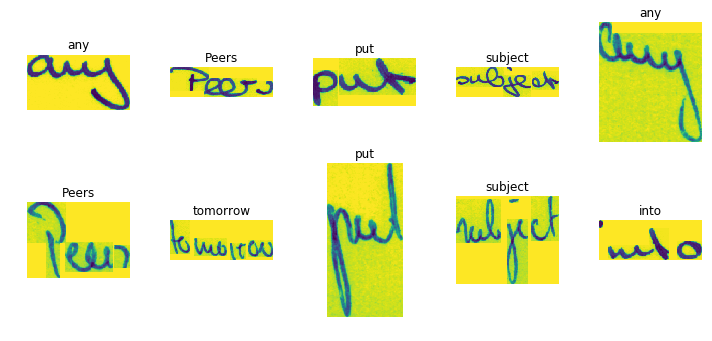

In [18]:

image_paths=[]
image_labels=[]
# show first 10 images
for i in range(10):
    image_path = filteredlabledataset[i][0]
    image_Label= filteredlabledataset[i][1]
    image_paths.append (image_path)
    image_labels.append (image_Label)


#init()
print(Style.BRIGHT + " original images with lable from dataset." + Style.RESET_ALL)
display_grid_of_images(image_paths, labels=image_labels, col=5, row=2, figsize=(10,5),save=True,filename="OrgImages.png")

#### Images are of different size, need to process them into fix size of 32x128 by maintaining aspect ratio, pad if needed

 Processed images with lable from dataset.


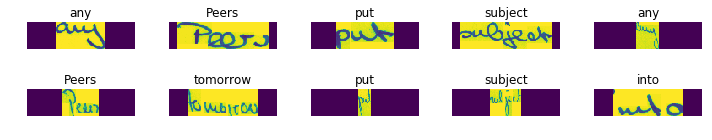

In [24]:
print(Style.BRIGHT + " Processed images with lable from dataset." + Style.RESET_ALL)
display_grid_of_images(image_paths, labels=image_labels, col=5, row=2, figsize=(10,2),save=True,filename="ProcessImages.png",fixsize=True,H=32,W=128)


#### create list of images and labels

In [21]:
images = []
labels = []
new_width = 128
new_height = 32
#for i in range(len(filteredMinCountdataset)-1):
for i in range(len(filteredlabledataset)-1):
    image_path = filteredlabledataset[i][0]
    image_Label= filteredlabledataset[i][1]
    #image_path = filteredMinCountdataset[i][0]
    #image_Label= filteredMinCountdataset[i][1]
    img = Image.open(image_path)
    resized_padded_image = resize_and_pad_image(img, new_width, new_height)
    images.append (resized_padded_image)
    labels.append (image_Label)

#### convert images to N-dimensional array

images array size:339968
images array type:<class 'numpy.ndarray'>
images array shape:(83, 32, 128)
images array, holding 83 images, each with a size of 32x128 pixels.
labels type:<class 'list'>
labels .length:83
first label in list:any
first image in images array is:any
image size:4096
image shape:(32, 128)


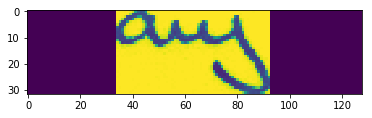

In [26]:
#convert to N-dimensional array
images = np.array(images)
#labels = np.array(images)

print("images array size:"+str(images.size))
print("images array type:"+ str(type(images)))
print("images array shape:"+ str(images.shape))
print("images array, holding " + str(images.shape[0])+" images, each with a size of "+str(images.shape[1])+"x"+str(images.shape[2])+" pixels.")

#print("labels.size:"+str(labels.size))
print("labels type:"+ str(type(labels)))
print("labels .length:"+str(len(labels)))
#print("labels.shape:"+ str(labels.shape))
print("first label in list:"+ str(labels[0]))

print("first image in images array is:"+ str(labels[0]))
iamge1 = images[0]
print("image size:"+str(iamge1.size))
#print("image type:"+ str(type(iamge1)))
print("image shape:"+ str(iamge1.shape))
plt.imshow(iamge1)
plt.savefig("firstImage.png")
plt.show()


#### Split data into training and testing sets

In [27]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [28]:
print("X_train.size:"+str(X_train.size))
print("X_train.type:"+ str(type(X_train)))
print("X_train.shape:"+ str(X_train.shape))
print("y_train.type:"+ str(type(y_train)))
print("y_train.size/len:"+str(len(y_train)))
print("X_test.size:"+str(X_test.size))
print("X_test.type:"+ str(type(X_test)))
print("X_test.shape:"+ str(X_test.shape))
print("y_test.type:"+ str(type(y_test)))
print("y_test.size/len:"+str(len(y_test)))

X_train.size:270336
X_train.type:<class 'numpy.ndarray'>
X_train.shape:(66, 32, 128)
y_train.type:<class 'list'>
y_train.size/len:66
X_test.size:69632
X_test.type:<class 'numpy.ndarray'>
X_test.shape:(17, 32, 128)
y_test.type:<class 'list'>
y_test.size/len:17


#### To use image sequences as input for a Hidden Markov Model (HMM), you need to transform the multi-dimensional image data into a 1D array or a sequence of vectors, which can be understood as a time series by the HMM.

In [31]:
# Set parameters
n_samples = images.shape[0] # total images
seq_length = images.shape[1] # rows of image
n_features = images.shape[2] # Assume flattened image patches/features, col of image
n_states = 10
print("total images " + str(n_samples)+" images, rows "+str(seq_length)+", col/patches/features "+str(n_features))

# Flatten the training and testing image sequences
X_train_flat = flatten_image_sequence(X_train)
print("size of training, flatten image sequences:"+str(X_train_flat.size))
print("X_train_flat.type:"+ str(type(X_train_flat)))
print("X_train_flat.shape:"+ str(X_train_flat.shape))

X_test_flat = flatten_image_sequence(X_test)
print("size of testing, flatten image sequences:"+str(X_test_flat.size))
print("X_test_flat.type:"+ str(type(X_test_flat)))
print("X_test_flat.shape:"+ str(X_test_flat.shape))

# Repeat labels to match flattened data
# same label for a rows of a single image
y_train_repeated = np.repeat(y_train, seq_length)
y_test_repeated = np.repeat(y_test, seq_length)
print("size of repeated labes to match flatten training data:"+str(y_train_repeated.size))
print("y_train_repeated.type:"+ str(type(y_train_repeated)))
print("y_train_repeated.shape:"+ str(y_train_repeated.shape))

print("size of repeated labes to match flatten testing data:"+str(y_test_repeated.size))
print("y_train_repeated.type:"+ str(type(y_test_repeated)))
print("y_train_repeated.shape:"+ str(y_test_repeated.shape))


total images 83 images, rows 32, col/patches/features 128
size of training, flatten image sequences:270336
X_train_flat.type:<class 'numpy.ndarray'>
X_train_flat.shape:(2112, 128)
size of testing, flatten image sequences:69632
X_test_flat.type:<class 'numpy.ndarray'>
X_test_flat.shape:(544, 128)
size of repeated labes to match flatten training data:2112
y_train_repeated.type:<class 'numpy.ndarray'>
y_train_repeated.shape:(2112,)
size of repeated labes to match flatten testing data:544
y_train_repeated.type:<class 'numpy.ndarray'>
y_train_repeated.shape:(544,)


#### Train the HMM for each class(words)

In [39]:
# Train the HMM for each class
models = {}
n_states=10
for class_label in np.unique(labels):
    #print(class_label)
    #model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=500)
    #model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=seq_length)
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=500)
    # Filter training data for the current class
    X_train_class = X_train_flat[y_train_repeated == class_label]
    if X_train_class.shape[0]!=0:
        #print("X_train_class.type:"+ str(type(X_train_class)))
        #print("X_train_class.size:"+str(X_train_class.size))
        #print("X_train_class.shape:"+ str(X_train_class.shape))
        #print("class_label:"+ class_label)
        sample1 = X_train_class[0:seq_length]
        #plt.imshow(sample1)
        #plt.show()

        
        model.fit(X_train_class)
        models[class_label] = model
       
        

Fitting a model with 83939 free scalar parameters with only 16384 data points will result in a degenerate solution.
Fitting a model with 83939 free scalar parameters with only 24576 data points will result in a degenerate solution.
Fitting a model with 83939 free scalar parameters with only 32768 data points will result in a degenerate solution.
Fitting a model with 83939 free scalar parameters with only 32768 data points will result in a degenerate solution.
Fitting a model with 83939 free scalar parameters with only 24576 data points will result in a degenerate solution.
Fitting a model with 83939 free scalar parameters with only 16384 data points will result in a degenerate solution.
Fitting a model with 83939 free scalar parameters with only 20480 data points will result in a degenerate solution.
Fitting a model with 83939 free scalar parameters with only 32768 data points will result in a degenerate solution.
Fitting a model with 83939 free scalar parameters with only 36864 data p

#### check accuracy of trained model on training data.

In [66]:
# Predict labels for the train set
predict_images = []
predicted_labels = []
for i in range(0, len(X_train_flat), seq_length):
    sample = X_train_flat[i:i+seq_length]
    #plt.imshow(sample)
    #plt.show()
    predict_images.append(sample)
    scores = {label: model.score(sample) for label, model in models.items()}
    predicted_label = max(scores, key=scores.get)
    predicted_labels.append(predicted_label)
    #print("predicted label:" + predicted_label)
    
# Evaluate the model
accuracy = accuracy_score(y_train, predicted_labels)
print("images:"+ str(len(predict_images)))
print("predicted labels:"+ str(len(predicted_labels)))
print("Lables:"+ str(len(y_train)))
print(f"Accuracy: {accuracy}")

images:66
predicted labels:66
Lables:66
Accuracy: 0.9696969696969697


#### few predicted images from training data

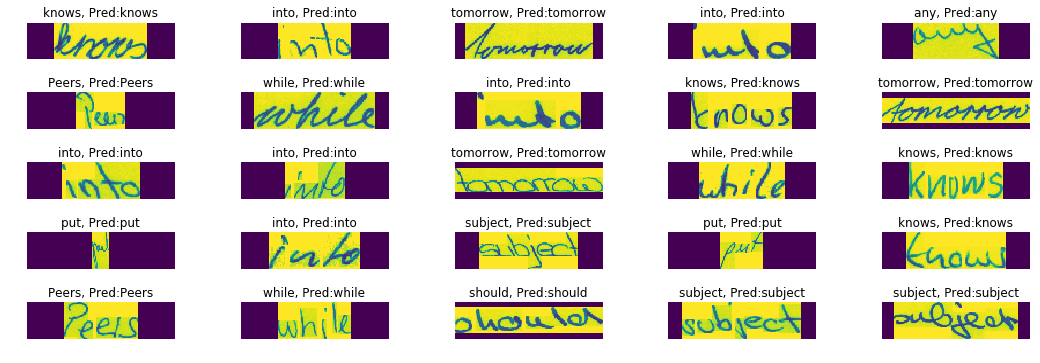

In [67]:
display_grid_of_images(predict_images, predicted_labels,y_train, col=5, row=5, figsize=(15,5),save=True,filename="train.png")

#### check accuracy of trained model on testing data

In [64]:
# Predict labels for the test set
predict_images = []
predicted_labels = []
for i in range(0, len(X_test_flat), seq_length):
    sample = X_test_flat[i:i+seq_length]
    #plt.imshow(sample)
    #plt.show()
    predict_images.append(sample)
    scores = {label: model.score(sample) for label, model in models.items()}
    predicted_label = max(scores, key=scores.get)
    predicted_labels.append(predicted_label)
    #print("predicted label:" + predicted_label)
    
# Evaluate the model
accuracy = accuracy_score(y_test, predicted_labels)
print("images:"+ str(len(predict_images)))
print("predicted labels:"+ str(len(predicted_labels)))
print("labels:"+ str(len(y_test)))
print(f"Accuracy: {accuracy}")

images:17
predicted labels:17
labels:17
Accuracy: 0.11764705882352941


#### few predicted images from testing data

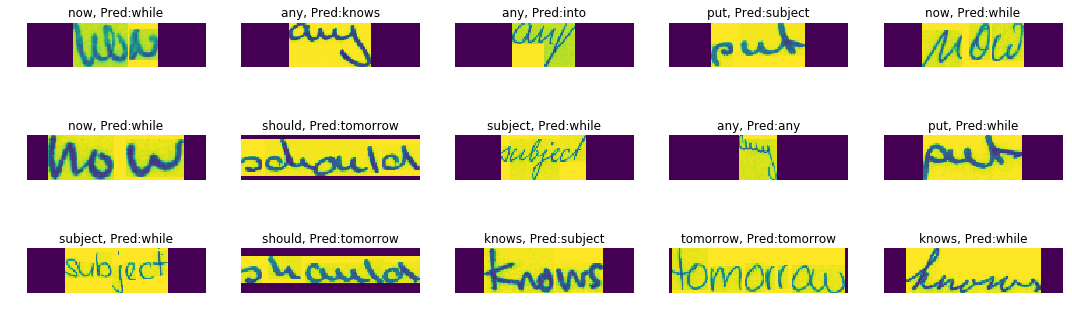

In [65]:
display_grid_of_images(predict_images, predicted_labels,y_test, col=5, row=3, figsize=(15,5),save=True,filename="test.png")

### Conclusion:
#### Accuracy of trained model on training data is 97%, but it falls to 10% for test data. This can be improve by increasing number of copies of same word by same writer or different writer. 